# 프로젝트 : augmentation 비교실험하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
print(len(ds_train))
print(len(ds_test))
num_classes = ds_info.features["label"].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete4DDKL7/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete4DDKL7/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
12000
8580


In [3]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 랜덤하게 augmentation 적용
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [4]:
# cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label



def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [5]:
# mixup
    
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [6]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False,with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### 1. Augmentation을 적용한 데이터셋 만들기
* augmentation 미적용
* augmentation 적용
* aug,cutmix 적용
* aug,mixup 적용

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
# 더미데이터 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

In [9]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_aug=True,with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,with_aug=True, with_mixup=True)

In [10]:
ds_train_aug

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [11]:
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [12]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

### 2. 모델 만들기


In [13]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


### 3. 모델 훈련하기

In [14]:
EPOCH = 20
train_per_step = int(ds_info.splits['train'].num_examples/16)
val_per_step = int(ds_info.splits['test'].num_examples/16)

In [15]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=train_per_step,
    validation_steps=val_per_step,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 102s 117ms/step - loss: 2.2059 - accuracy: 0.4478 - val_loss: 3.5456 - val_accuracy: 0.1826
Epoch 2/20
750/750 [==============================] - 87s 116ms/step - loss: 0.6744 - accuracy: 0.8216 - val_loss: 1.1202 - val_accuracy: 0.6729
Epoch 3/20
750/750 [==============================] - 87s 116ms/step - loss: 0.1811 - accuracy: 0.9674 - val_loss: 0.9426 - val_accuracy: 0.7241
Epoch 4/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0460 - accuracy: 0.9979 - val_loss: 0.8903 - val_accuracy: 0.7495
Epoch 5/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0198 - accuracy: 0.9997 - val_loss: 0.9045 - val_accuracy: 0.7497
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0127 - accuracy: 0.9999 - val_loss: 0.9132 - val_accuracy: 0.7477
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9245 - val_accuracy: 0.

In [16]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50= aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=train_per_step,
    validation_steps=val_per_step,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 94s 117ms/step - loss: 2.2737 - accuracy: 0.4292 - val_loss: 2.5530 - val_accuracy: 0.3289
Epoch 2/20
750/750 [==============================] - 87s 116ms/step - loss: 0.9363 - accuracy: 0.7324 - val_loss: 1.1767 - val_accuracy: 0.6537
Epoch 3/20
750/750 [==============================] - 87s 116ms/step - loss: 0.4777 - accuracy: 0.8702 - val_loss: 1.1196 - val_accuracy: 0.6739
Epoch 4/20
750/750 [==============================] - 87s 116ms/step - loss: 0.2498 - accuracy: 0.9450 - val_loss: 1.1203 - val_accuracy: 0.6827
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 0.1241 - accuracy: 0.9793 - val_loss: 1.0855 - val_accuracy: 0.6966
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0736 - accuracy: 0.9903 - val_loss: 0.9496 - val_accuracy: 0.7344
Epoch 7/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0436 - accuracy: 0.9950 - val_loss: 1.0951 - val_accuracy: 0.7

In [17]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=train_per_step,
    validation_steps=val_per_step,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 99s 121ms/step - loss: 3.8678 - accuracy: 0.2026 - val_loss: 3.1963 - val_accuracy: 0.2317
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 3.0317 - accuracy: 0.4062 - val_loss: 1.3977 - val_accuracy: 0.6058
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 2.7472 - accuracy: 0.4961 - val_loss: 1.2815 - val_accuracy: 0.6424
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 2.5688 - accuracy: 0.5462 - val_loss: 1.2553 - val_accuracy: 0.6576
Epoch 5/20
750/750 [==============================] - 90s 119ms/step - loss: 2.4213 - accuracy: 0.5873 - val_loss: 1.2820 - val_accuracy: 0.6487
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 2.3254 - accuracy: 0.6238 - val_loss: 1.2037 - val_accuracy: 0.6655
Epoch 7/20
750/750 [==============================] - 90s 121ms/step - loss: 2.2384 - accuracy: 0.6537 - val_loss: 1.1794 - val_ac

In [18]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=train_per_step,
    validation_steps=val_per_step,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 99s 121ms/step - loss: 3.7499 - accuracy: 0.2288 - val_loss: 3.7842 - val_accuracy: 0.1556
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 2.9167 - accuracy: 0.4603 - val_loss: 1.5399 - val_accuracy: 0.5668
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 2.6456 - accuracy: 0.5552 - val_loss: 1.7350 - val_accuracy: 0.5361
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 2.4915 - accuracy: 0.6102 - val_loss: 1.3003 - val_accuracy: 0.6316
Epoch 5/20
750/750 [==============================] - 92s 122ms/step - loss: 2.3847 - accuracy: 0.6579 - val_loss: 1.2978 - val_accuracy: 0.6453
Epoch 6/20
750/750 [==============================] - 92s 123ms/step - loss: 2.2830 - accuracy: 0.6921 - val_loss: 1.3543 - val_accuracy: 0.6322
Epoch 7/20
750/750 [==============================] - 92s 123ms/step - loss: 2.1986 - accuracy: 0.7266 - val_loss: 1.3307 - val_accuracy: 0.6

### 4. 훈련 과정 시각화 하기

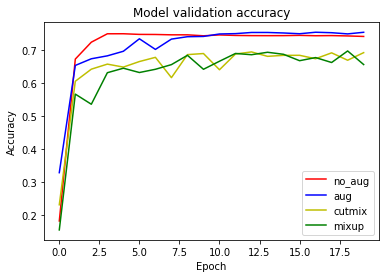

In [20]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'],'r')
plt.plot(history_aug_resnet50.history['val_accuracy'],'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'],'y')
plt.plot(history_mixup_resnet50.history['val_accuracy'],'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['no_aug','aug','cutmix','mixup'])
plt.show()

### 5. Augmentation에 의한 모델 성능 비교
일반적인 aumentation 적용시킨 데이터셋의 결과가 가장 좋았습니다.
cutmix와 mixup은 단독으로도 사용해봤는데 결과가 비슷합니다.

# 회고합시다.
shape가 안맞아서 진짜 한참 해멨었는데 알고보니 label이 onehot인코딩 되어있으면 loss function을 'sparse_categorical_crossentropy'가 아니라 'categorical_crossentropy'로 학습을 시켜줘야했습니다.
>https://stackoverflow.com/questions/58398491/valueerror-shape-mismatch-the-shape-of-labels-received-15-should-equal-th